# MNIST Dynamic Filter Classification

**Note**: This notebook is desinged to run on GPU runtime.

**[MDF-01]**

Install libraries.

In [1]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.1
jax                           0.3.21
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[MDF-02]**

Import modules.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame
from tensorflow.keras.datasets import mnist

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state, checkpoints

plt.rcParams.update({'font.size': 12})

**[MDF-03]**

Download the MNIST dataset and store into NumPy arrays.

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape([-1, 784]).astype('float32') / 255
test_images = test_images.reshape([-1, 784]).astype('float32') / 255
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

11501568/11490434 [==============================] - 0s 0us/step


**[MDF-04]**

Define a function to split the dataset into batches.

In [4]:
def create_batches(data, batch_size):
    num_batches, mod = divmod(len(data), batch_size)
    data_batched = np.array_split(data[:num_batches * batch_size], num_batches)
    if mod: # Last batch is smaller than batch_size
        data_batched.append(data[num_batches * batch_size:])
    data_batched = [jnp.asarray(x) for x in data_batched]
    return data_batched

**[MDF-05]**

Define CNN model with a single convolutional filter layer.

In [5]:
class SingleLayerCNN(nn.Module):
    @nn.compact
    def __call__(self, x, get_logits=False):
        x = x.reshape([-1, 28, 28, 1])
        x = nn.Conv(features=16, kernel_size=(5, 5), use_bias=True,
                    name='ConvLayer')(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape([x.shape[0], -1]) # Flatten
        x = nn.Dense(features=1024)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        if get_logits:
            return x
        x = nn.softmax(x)
        return x

**[MDF-06]**

Generate inital parameter values.

In [6]:
key, key1 = random.split(random.PRNGKey(0))
variables = SingleLayerCNN().init(key1, train_images[0:1])

jax.tree_util.tree_map(lambda x: x.shape, variables['params'])

FrozenDict({
    ConvLayer: {
        bias: (16,),
        kernel: (5, 5, 1, 16),
    },
    Dense_0: {
        bias: (1024,),
        kernel: (3136, 1024),
    },
    Dense_1: {
        bias: (10,),
        kernel: (1024, 10),
    },
})

**[MDF-07]**

Create a training state object.

In [7]:
state = train_state.TrainState.create(
    apply_fn=SingleLayerCNN().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.001))

**[MDF-08]**

Define a loss function as the categorical cross entoropy.

In [8]:
@jax.jit
def loss_fn(params, state, inputs, labels):
    logits = state.apply_fn({'params': params}, inputs, get_logits=True)
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    acc = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))
    return loss, acc

**[MDF-09]**

Define a function to apply a single training step that returns a new training state.

In [9]:
@jax.jit
def train_step(state, inputs, labels):
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(
        state.params, state, inputs, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, acc

**[MDF-10]**

Define a function to apply the training steps for one epoch.

In [10]:
def train_epoch(state, input_batched, label_batched, eval=False):
    loss_history, acc_history = [], []
    for inputs, labels in zip(input_batched, label_batched):
        new_state, loss, acc = train_step(state, inputs, labels)
        if not eval:
            state = new_state
        loss_history.append(jax.device_get(loss).tolist())
        acc_history.append(jax.device_get(acc).tolist())
    return state, np.mean(loss_history), np.mean(acc_history)

**[MDF-11]**

Define a function to repeat the training steps for multiple epochs.

In [11]:
def fit(state, train_inputs, train_labels, test_inputs, test_labels,
        epochs, batch_size):

    train_inputs_batched = create_batches(train_inputs, batch_size)
    train_labels_batched = create_batches(train_labels, batch_size)
    test_inputs_batched = create_batches(test_inputs, batch_size)
    test_labels_batched = create_batches(test_labels, batch_size)

    loss_history_train, acc_history_train = [], []
    loss_history_test, acc_history_test = [], []

    for epoch in range(1, epochs+1):
        state, loss_train, acc_train = train_epoch(
            state, train_inputs_batched, train_labels_batched)
        loss_history_train.append(loss_train)
        acc_history_train.append(acc_train)

        _ , loss_test, acc_test = train_epoch(
            state, test_inputs_batched, test_labels_batched, eval=True)
        loss_history_test.append(loss_test)
        acc_history_test.append(acc_test)

        print ('Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f} / '.format(
            epoch, loss_train, acc_train), end='', flush=True)
        print ('Loss(Test): {:.4f}, Accuracy(Test): {:.4f}'.format(
            loss_test, acc_test), flush=True)
  
    history = {'loss_train': loss_history_train,
               'acc_train': acc_history_train,
               'loss_test': loss_history_test,
               'acc_test': acc_history_test}
  
    return state, history

**[MDF-12]**

Repeat the training steps for multiple epochs.

In [12]:
%%time
state, history = fit(state, 
                     train_images, train_labels, test_images, test_labels,
                     epochs=16, batch_size=128)

Epoch: 1, Loss: 0.1721, Accuracy: 0.9481 / Loss(Test): 0.0679, Accuracy(Test): 0.9764
Epoch: 2, Loss: 0.0508, Accuracy: 0.9845 / Loss(Test): 0.0486, Accuracy(Test): 0.9833
Epoch: 3, Loss: 0.0289, Accuracy: 0.9917 / Loss(Test): 0.0448, Accuracy(Test): 0.9856
Epoch: 4, Loss: 0.0181, Accuracy: 0.9948 / Loss(Test): 0.0527, Accuracy(Test): 0.9841
Epoch: 5, Loss: 0.0125, Accuracy: 0.9962 / Loss(Test): 0.0542, Accuracy(Test): 0.9848
Epoch: 6, Loss: 0.0115, Accuracy: 0.9967 / Loss(Test): 0.0522, Accuracy(Test): 0.9845
Epoch: 7, Loss: 0.0095, Accuracy: 0.9968 / Loss(Test): 0.0536, Accuracy(Test): 0.9859
Epoch: 8, Loss: 0.0060, Accuracy: 0.9980 / Loss(Test): 0.0523, Accuracy(Test): 0.9866
Epoch: 9, Loss: 0.0064, Accuracy: 0.9979 / Loss(Test): 0.0501, Accuracy(Test): 0.9872
Epoch: 10, Loss: 0.0056, Accuracy: 0.9982 / Loss(Test): 0.0591, Accuracy(Test): 0.9853
Epoch: 11, Loss: 0.0053, Accuracy: 0.9982 / Loss(Test): 0.0521, Accuracy(Test): 0.9872
Epoch: 12, Loss: 0.0048, Accuracy: 0.9985 / Loss(Tes

**[MDF-13]**

Show charts of the accuracy history and the loss history.

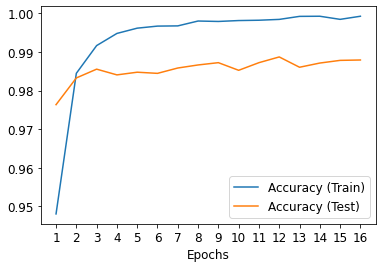

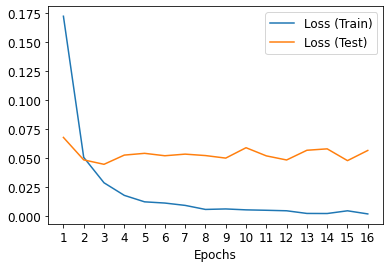

In [13]:
df = DataFrame({'Accuracy (Train)': history['acc_train'],
                'Accuracy (Test)': history['acc_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'Loss (Train)': history['loss_train'],
                'Loss (Test)': history['loss_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

**[MDF-14]**

Mount Google Drive content.

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**[MDF-15]**

Save a TrainState checkpoint file.

In [15]:
checkpoints.save_checkpoint(
    ckpt_dir='/content/gdrive/My Drive/checkpoints',
    prefix='SingleLayerCNN_checkpoint_',
    target=state, step=16, overwrite=True)

'/content/gdrive/My Drive/checkpoints/SingleLayerCNN_checkpoint_16'

**[MDF-16]**

Check filesize of the checkpoint file.

In [16]:
!ls -lh '/content/gdrive/My Drive/checkpoints/'

total 75M
-rw------- 1 root root 38M Oct  5 01:56 DoubleLayerCNN_checkpoint_16
-rw------- 1 root root 37M Oct  5 01:58 SingleLayerCNN_checkpoint_16
